In [1]:
import csv
import numpy as np
import pandas as pd
import torch
import torch.nn as nn

# Featurizer class definition

class Featurizer():
    
    def __init__(self, fp_len, fp_type):
        self.fp_len = fp_len
        self.fp_type = fp_type
    
    def __call__(self, df):
        fingerprints = []
        labels = []
        
        df = df[df['Ki']<=1e4]
        df = df[df['Ki']>0.01]
        labels = df['Ki']
        
        fp = []
        for index, row in df.iterrows():
            fp = row[1:self.fp_len+1]
            fingerprints.append(fp)
            
        fingerprints = np.array(fingerprints)
        labels = np.array(labels)
        return fingerprints, labels
        
class KlekFeaturizer(Featurizer):
    def __init__(self, fp_len=4860, fp_type='Klek',):
        super().__init__(fp_len, fp_type)
    
class MACCSFeaturizer(Featurizer):
    def __init__(self, fp_len=166, fp_type='MACCS'):
        super().__init__(fp_len, fp_type)
        
class SubFeaturizer(Featurizer):
    def __init__(self, fp_len=307, fp_type='Sub'):
        super().__init__(fp_len, fp_type)

In [2]:
# text file to DataFrame object

filename = '../ready_datasets/d2_SubFP_final_file.csv'
df = pd.read_csv(filename)
df = df.dropna()

featurizer = SubFeaturizer()
fp_train, ki_train = featurizer(df)

fp_train = torch.from_numpy(fp_train)
ki_train = torch.from_numpy(ki_train)

assert fp_train.shape[0] == ki_train.shape[0], 'X_train and y_train rows do not match'

In [3]:
fp_train.shape

torch.Size([10325, 307])

In [4]:
# data loader

from torch.utils.data import DataLoader, TensorDataset

tensor_ds = TensorDataset(fp_train, ki_train)
train = tensor_ds

train_dataloader = DataLoader(train, batch_size=64, shuffle=True)

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable

class Encoder(nn.Module):
    def __init__(self, input_size, output_size):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 16)
        self.fc41 = nn.Linear(16, output_size)
        self.fc42 = nn.Linear(16, output_size)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        h1 = self.relu(self.fc1(x))
        h2 = self.relu(self.fc2(h1))
        h3 = self.relu(self.fc3(h2))
        mu = self.fc41(h3)
        logvar = self.fc41(h3)
        return mu, logvar

class Decoder(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 64)
        self.fc3 = nn.Linear(64, 128)
        self.fc4 = nn.Linear(128, output_size)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        h1 = self.relu(self.fc1(x))
        h2 = self.relu(self.fc2(h1))
        h3 = self.relu(self.fc3(h2))
        out = self.fc4(h3)
        return self.sigmoid(out)

class VAE(nn.Module):
    def __init__(self, input_size, latent_size):
        torch.set_default_dtype(torch.float64)
        super(VAE, self).__init__()
        self.encoder = Encoder(input_size, latent_size)
        self.decoder = Decoder(latent_size, 128, input_size)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu)

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        return self.decoder(z), mu, logvar


In [20]:
class VAELoss(nn.Module):
    def __init__(self):
        super(VAELoss, self).__init__()

    def forward(self, recon_x, x, mu, logvar):
        BCE = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')
        KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        return BCE + KLD

In [21]:
fp_len = featurizer.fp_len
code_len = 8

def train_VAE(train_dataloader, epochs=40, device=device):
    model = VAE(fp_len, code_len)
    criterion = VAELoss()
    if device == 'cuda':
        model.cuda()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)
    
    for epoch in range(epochs):
        for (fp, _) in train_dataloader:
            if device == 'cuda':
                fp = fp.cuda()
            encoded, mu, logvar = model(fp)
            loss = criterion(encoded, fp, mu, logvar)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        print(f'Epoch: {epoch+1}, Loss: {loss.item():.4f}')
    return model

In [22]:
model = train_VAE(train_dataloader, epochs=40, device=device)

Epoch: 1, Loss: 4421.5883
Epoch: 2, Loss: 4331.8641
Epoch: 3, Loss: 4119.9208
Epoch: 4, Loss: 3787.1273
Epoch: 5, Loss: 3132.3967
Epoch: 6, Loss: 1942.2480
Epoch: 7, Loss: 1413.1308
Epoch: 8, Loss: 960.8732
Epoch: 9, Loss: 786.6771
Epoch: 10, Loss: 679.4589
Epoch: 11, Loss: 733.9202
Epoch: 12, Loss: 615.1181
Epoch: 13, Loss: 535.2877
Epoch: 14, Loss: 565.1539
Epoch: 15, Loss: 534.0005
Epoch: 16, Loss: 526.8705
Epoch: 17, Loss: 417.6028
Epoch: 18, Loss: 460.0863
Epoch: 19, Loss: 472.1240
Epoch: 20, Loss: 422.1747
Epoch: 21, Loss: 441.9772
Epoch: 22, Loss: 451.7685
Epoch: 23, Loss: 424.1421
Epoch: 24, Loss: 455.0236
Epoch: 25, Loss: 514.3031
Epoch: 26, Loss: 439.3612
Epoch: 27, Loss: 403.1411
Epoch: 28, Loss: 365.5227
Epoch: 29, Loss: 399.1963
Epoch: 30, Loss: 380.1400
Epoch: 31, Loss: 373.6931
Epoch: 32, Loss: 388.6471
Epoch: 33, Loss: 351.6791
Epoch: 34, Loss: 496.6147
Epoch: 35, Loss: 418.3711
Epoch: 36, Loss: 378.5490
Epoch: 37, Loss: 407.3932
Epoch: 38, Loss: 407.9817
Epoch: 39, Los

In [23]:
# encode all data to latent space
encoded = []
for fp in fp_train:
    encoder = model.encoder
    if device == 'cuda':
        fp = fp.cuda()
        mu, logvar = encoder(fp)
        latent = model.reparameterize(mu, logvar)
        encoded.append(latent.detach().cpu().numpy())
    else:
        mu, logvar = encoder(fp)
        latent = model.reparameterize(mu, logvar)
        encoded.append(latent.detach().numpy())

In [27]:
encoded = np.array(encoded)

In [28]:
# filter for active compounds only

activity = (ki_train < 10)
activity = np.array(activity)

In [29]:
vae_results = pd.DataFrame(encoded)
vae_results['activity'] = activity

In [30]:
# plot latent space
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# pca reduction

pca = PCA(n_components=2)
pca_results = pca.fit_transform(encoded)
pca_results = pd.DataFrame(pca_results)
pca_results['activity'] = activity

# t-SNE reduction

print('...tSNE...')
tsne = tsne = TSNE(perplexity=20, learning_rate=100, verbose=3)
tsne_results = pd.DataFrame(tsne.fit_transform(encoded))
tsne_results['activity'] = activity

...tSNE...
[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 10325 samples in 0.012s...
[t-SNE] Computed neighbors for 10325 samples in 1.689s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10325
[t-SNE] Computed conditional probabilities for sample 2000 / 10325
[t-SNE] Computed conditional probabilities for sample 3000 / 10325
[t-SNE] Computed conditional probabilities for sample 4000 / 10325
[t-SNE] Computed conditional probabilities for sample 5000 / 10325
[t-SNE] Computed conditional probabilities for sample 6000 / 10325
[t-SNE] Computed conditional probabilities for sample 7000 / 10325
[t-SNE] Computed conditional probabilities for sample 8000 / 10325
[t-SNE] Computed conditional probabilities for sample 9000 / 10325
[t-SNE] Computed conditional probabilities for sample 10000 / 10325
[t-SNE] Computed conditional probabilities for sample 10325 / 10325
[t-SNE] Mean sigma: 0.649749
[t-SNE] Computed conditional probabilities in 0.254s
[t-SNE] Iteration 50: err

Text(0, 0.5, 'PC2')

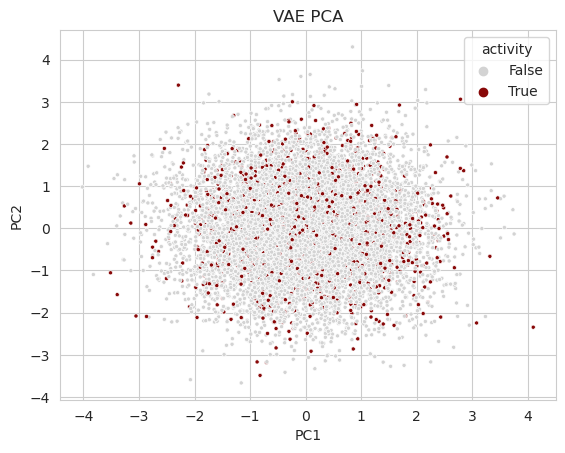

In [32]:
import seaborn as sns

sns.set_style('whitegrid')
colors = ['#D3D3D3', '#880808']
sns.scatterplot(x=0, y=1, hue='activity', data=pca_results, marker='.', palette=colors)
plt.title('VAE PCA')
plt.xlabel('PC1')
plt.ylabel('PC2')

Text(0, 0.5, 'Ax2')

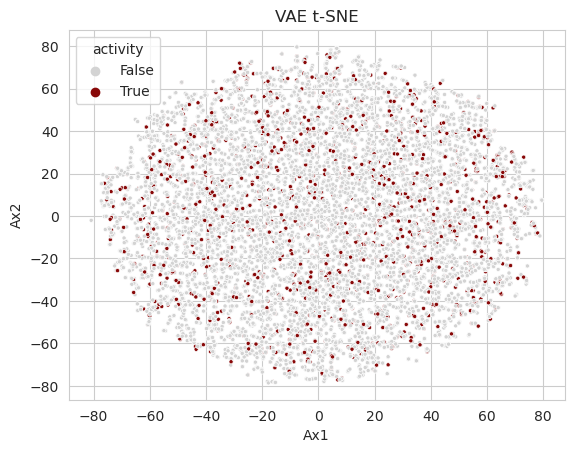

In [33]:
sns.scatterplot(x=0, y=1, hue='activity', data=tsne_results, marker='.', palette=colors)
plt.title('VAE t-SNE')
plt.xlabel('Ax1')
plt.ylabel('Ax2')